In [6]:
%load_ext autoreload
%autoreload 2

import sys

import os
from Bio import SeqIO
import regex as re
import pandas as pd

from adjustText import adjust_text

import pandas as pd

# from bm_tools.data import Data
# from bm_tools.plots import Plots

import matplotlib.pyplot as plt

# get data
data = pd.read_pickle("./data/datasets/islets_rna_prot_dataset.pkl")
sample_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_sample_metadata.pkl")
feature_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_feature_metadata.pkl")

sys.path.append("src.py")
from src import Utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [F03] Selected Hits Transcriptome - Proteome correlation

1. Compute the median for each protein in transriptomics and proteomics data
2. Select a set of marker proteins for each cell type:
    - Beta-cells: SLC2A2, MAFA
    - Delta-cells: RESP18, SCG5, HHEX
    - Alpha-cells: MAFA, IRX1, IRX2, MAFB

In [3]:
# Load the fasta from the proteomics part to get the matching protein / gene names
fasta_path = "/Users/vincenthbrennsteiner/Documents/mann_labs/_git_repositories/projects/collaborations/MaTh_Jun24/data/fastas"
fasta_name = "UP000000589_10090_additional.fasta" 

# reverse the dict but handle one-to-many mapping by concatenation; costly due to exhaustive search
with open(os.path.join(fasta_path, fasta_name)) as fasta_file:
    fasta = SeqIO.parse(fasta_file, 'fasta')
    id_to_gene = {x.id.split("|")[1] : ';'.join([x for x in re.findall(r'GN=([^\s]+)', x.description)]) for x in fasta}
    gene_to_id = {}
    for gene in id_to_gene.values():
        ids = ' OR '.join([x for x in id_to_gene if id_to_gene[x] == gene])
        gene_to_id[gene.upper()] = ids

In [4]:
# Annotate markers
markers = {
    'alpha' : ['MAFA', 'IRX1', 'IRX2', 'MAFB', 'GCG', 'TTR', 'Pou3f4'],
    'beta' : ['SLC2A2', 'MAFA', 'INS2', 'NKX6-1', 'UCN3', 'GLP1R'],
    'delta' : ['Resp18', 'Scg5', 'Hhex', 'SST', 'Rbp4'],
}
marker_df = pd.DataFrame([(cell_type, gene.upper()) for cell_type, genes in markers.items() for gene in genes], columns = ['cell_type', 'gene'])

marker_ids = {marker : gene_to_id.get(marker.upper(), None) for marker in marker_df['gene'].values}

# clean marker ids: if there is a P or Q id, we keep it; bit hacky, refactor later
main_marker_ids = {}
for gene, ids in marker_ids.items():
    id_list = ids.split(' OR ')
    main_id = [x for x in id_list if x.startswith('P') or x.startswith('Q') or x.startswith('O')] 
    main_marker_ids[gene] = main_id[0] if len(main_id) > 0 else None

marker_ids = main_marker_ids
id2gene = {v : k for k, v in marker_ids.items()}

with open('marker_ids.csv', 'w') as f:
    for gene, gene_id in marker_ids.items():
        f.write(f"{gene}\t{gene_id}\n")

# Generate a dataframe of markers
marker_id_df = pd.DataFrame([(gene, gene_id) for gene, gene_id in marker_ids.items()], columns = ['gene', 'uniprot_id'])
marker_df = marker_df.merge(marker_id_df, on = 'gene')

# generate the median dataset: 
median_dataset = data.merge(sample_metadata[['sample', 'treat', 'readout']], left_index = True, right_index = True).groupby(['sample', 'treat', 'readout']).median()
median_dataset.index = median_dataset.index.map(lambda x: "_".join(x))

In [5]:
# get matching dataset columns: any column name that partially contains the marker id
marker_columns = []
found_markers = []
for marker in marker_df['uniprot_id'].values:
    matches = [col for col in median_dataset.columns if marker in col]
    if matches:
        marker_columns.append(matches[0])
        found_markers.append(marker)

marker_data = median_dataset[marker_columns].copy()

# Format the readout column of the marker data
marker_data['readout'] = marker_data.index.str.split('_').str[2]

# Split and merge marker data for proteomics and transcriptomics visualization 
marker_data_proteomics = marker_data[marker_data['readout'] == 'proteomics'].T.drop('readout')
marker_data_transcriptomics = marker_data[marker_data['readout'] == 'transcriptomics'].T.drop('readout')
marker_data = pd.concat([marker_data_proteomics, marker_data_transcriptomics], axis = 1)

0 [0.44627752 0.06554703]
5 [ 0.09571158 -0.89819196]
0 [ 0.42877028 -0.75239124]
4 [0.89556349 0.81627037]
0 [-0.58032054  0.66003063]
4 [0.18742623 0.13417562]


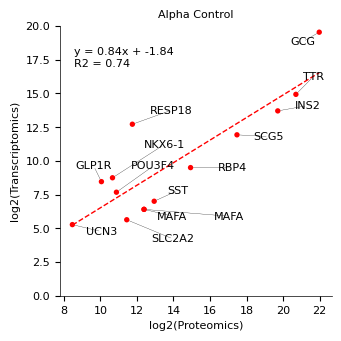

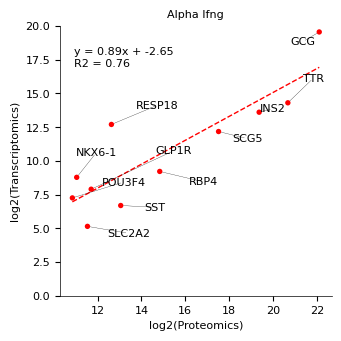

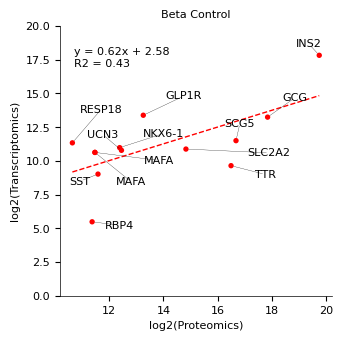

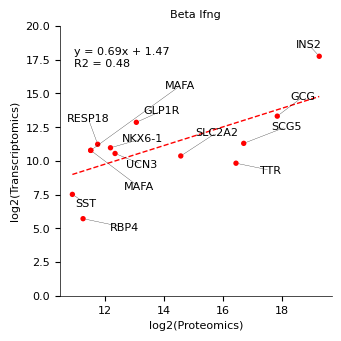

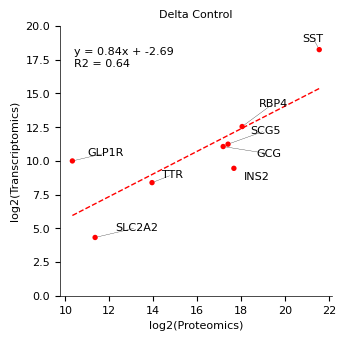

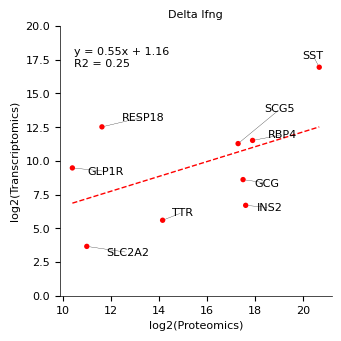

In [9]:
for cell in ['alpha', 'beta', 'delta']:
    for treatment in ['control', 'ifng']:
        plot_df = marker_data[[f'{cell}_{treatment}_proteomics', f'{cell}_{treatment}_transcriptomics']]
        f, axs = Utils.scatter(
            data = plot_df,
            metadata = None,
            x_col = f'{cell}_{treatment}_proteomics',
            y_col = f'{cell}_{treatment}_transcriptomics',
            highlight_lookup_column = 'index',
            highlight_labels_column = 'index',
            scatter_kwargs = {'s': 60},
            xlabel = 'log2(Proteomics)',
            ylabel = 'log2(Transcriptomics)',
            title = f'{cell.capitalize()} {treatment.capitalize()}',
            linear_regression = True,
            show_equation = True,
            ylim = (0, 20),
            show = False,
            base_color = 'red'
        )
        
        # Label points
        plot_df = plot_df.copy()
        plot_df['gene'] = plot_df.index.map(lambda x: id2gene.get(x, x))
        plot_df = plot_df.dropna()
        texts = []
        for i, row in plot_df.iterrows():
            texts.append(axs.text(row[f'{cell}_{treatment}_proteomics'], row[f'{cell}_{treatment}_transcriptomics'], row['gene'], fontsize = 8))
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', linewidth = 0.2), ax=axs, min_arrow_len = 0.5, expand_points=(1.1, 1.1), ha='left', va='bottom')

        # save plot
        Utils.save_figure(
            fig = f, 
            filename = f"fig_03_scatterplot_{cell}_{treatment}.svg",
            output_dir = "./assets/20250423_revision_figures/",
            dpi = 300,
            paper_height = "single",
            paper_width = "single",
        )

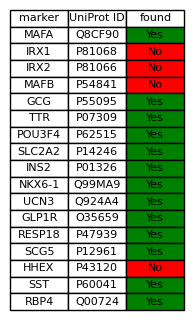

In [10]:
# visualize the markers which were found vs. the ones that were not found
all_marker_genes = list(marker_ids.keys())
found_marker_genes = [k for k, v in marker_ids.items() if v in found_markers]

# plt table with coloring
plot_table = pd.DataFrame({
    "marker" : all_marker_genes,
    "UniProt ID" : [marker_ids[m] for m in all_marker_genes],
    "found" : "No",
})
plot_table.loc[plot_table['marker'].isin(found_marker_genes), 'found'] = "Yes"

# plot
fig, ax = plt.subplots(figsize = (2.25, 0.075 * len(plot_table),))
ax.axis('off')
status_colors = ['red' if x == 'No' else 'green' for x in plot_table['found']]
table = ax.table(cellText = plot_table.values, colLabels = plot_table.columns, loc = 'center', cellLoc = 'center')

table.auto_set_font_size(False)  # Disable automatic font scaling
table.set_fontsize(8)  # Set font size manually

for row in range(len(plot_table)):
    table[(row + 1, 2)].set_facecolor(status_colors[row])

# save plot
fig.savefig("./assets/20250423_revision_figures/fig_03_marker_table_new.svg", dpi = 300, bbox_inches = 'tight')